# Text classification and sentiment analysis: Yelp Reviews

Once text data has been converted into numerical features using the natural language processing techniques discussed in the previous sections, text classification works just like any other classification task.

In this notebook, we will apply these preprocessing technique to Yelp business reviews to classify them by review scores and sentiment polarity.

## Imports

In [1]:
%matplotlib inline
import warnings
from collections import Counter, OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import pyarrow as pa   
import pyarrow.parquet as pq
from fastparquet import ParquetFile 
from scipy import sparse
from scipy.spatial.distance import pdist, squareform

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import seaborn as sns

# spacy, textblob and nltk for language processing
from textblob import TextBlob, Word

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.externals import joblib

import lightgbm as lgb

import json
from time import clock, time

In [2]:
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

## Yelp Challenge: business reviews dataset

Finally, we apply sentiment analysis to the significantly larger Yelp business review dataset with five outcome classes. 

The data consists of several files with information on the business, the user, the review and other aspects that Yelp provides to encourage data science innovation. 

We will use around six million reviews produced over the 2010-2018 period. In addition to the text features resulting from the review texts, we will also use other information submitted with the review about the user. 

The [Yelp](https://www.yelp.com/dataset) dataset covers a subset of Yelp's businesses, reviews, and user data. 

You can download the data come in json format after accepting the license. It contains 3.6GB (compressed) and around 9GB (uncompressed) of text data. 

After download, extract the user.json and reviews.json files into to `data/yelp/json`

### Set up data directories

We parse the json files and store the result in parquet format in our cental data directory so we can reuse the cleaned data. You can remove the large json files after parsing.

In [ ]:
data_dir = Path('../data')

In [3]:
yelp_dir = Path('data', 'yelp')
parquet_dir = data_dir / 'yelp'
if not parquet_dir.exists():
    parquet_dir.mkdir(exist_ok=True)
text_features_dir = yelp_dir / 'text_features'
if not text_features_dir.exists():
    text_features_dir.mkdir(exist_ok=True)    

### Parse json and store as parquet files

In [4]:
for file in ['review', 'user']:
    print(file)
    json_file = yelp_dir / 'json' / f'{file}.json'
    parquet_file = parquet_dir / f'{file}.parquet'

    data = json_file.read_text(encoding='utf-8')
    json_data = '[' + ','.join([l.strip()
                                for l in data.split('\n') if l.strip()]) + ']\n'
    data = json.loads(json_data)
    df = json_normalize(data)
    if file == 'review':
        df.date = pd.to_datetime(df.date)
        latest = df.date.max()
        df['year'] = df.date.dt.year
        df['month'] = df.date.dt.month
        df = df.drop(['date', 'business_id', 'review_id'], axis=1)
    if file == 'user':
        df.yelping_since = pd.to_datetime(df.yelping_since)
        df = (df.assign(member_yrs=lambda x: (latest - x.yelping_since)
                        .dt.days.div(365).astype(int))
              .drop(['elite', 'friends', 'name', 'yelping_since'], axis=1))
    df.dropna(how='all', axis=1).to_parquet(parquet_file)


review
user


In [5]:
user = pd.read_parquet(parquet_dir / 'user.parquet')
user.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1637138 entries, 0 to 1637137
Data columns (total 19 columns):
average_stars         1637138 non-null float64
compliment_cool       1637138 non-null int64
compliment_cute       1637138 non-null int64
compliment_funny      1637138 non-null int64
compliment_hot        1637138 non-null int64
compliment_list       1637138 non-null int64
compliment_more       1637138 non-null int64
compliment_note       1637138 non-null int64
compliment_photos     1637138 non-null int64
compliment_plain      1637138 non-null int64
compliment_profile    1637138 non-null int64
compliment_writer     1637138 non-null int64
cool                  1637138 non-null int64
fans                  1637138 non-null int64
funny                 1637138 non-null int64
review_count          1637138 non-null int64
useful                1637138 non-null int64
user_id               1637138 non-null object
member_yrs            1637138 non-null int64
dtypes: float64(1), int64(17)

In [6]:
user.head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool,fans,funny,review_count,useful,user_id,member_yrs
0,4.03,1,0,1,2,0,0,1,0,1,0,2,25,5,17,95,84,l6BmjZMeQD3rDxWUbiAiow,5
1,3.63,1,0,1,1,0,0,0,0,0,0,0,16,4,22,33,48,4XChL029mKr5hydo79Ljxg,5
2,3.71,0,0,0,0,0,0,1,0,0,0,0,10,0,8,16,28,bc8C_eETBWL0olvFSJJd0w,5
3,4.85,0,0,0,1,0,0,0,0,2,0,1,14,5,4,17,30,dD0gZpBctWGdWo9WlGuhlA,4
4,4.08,80,0,80,28,1,1,16,5,57,0,25,665,39,279,361,1114,MM4RJAeH6yuaN8oZDSt0RA,5


In [8]:
review = pd.read_parquet(parquet_dir / 'review.parquet')
review.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6685900 entries, 0 to 6685899
Data columns (total 8 columns):
cool       6685900 non-null int64
funny      6685900 non-null int64
stars      6685900 non-null float64
text       6685900 non-null object
useful     6685900 non-null int64
user_id    6685900 non-null object
year       6685900 non-null int64
month      6685900 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 408.1+ MB


### Merge review and user files

In [9]:
combined = (review
            .merge(user, on='user_id', how='left', suffixes=['', '_user'])
            .drop('user_id', axis=1))
combined = combined[combined.stars > 0]
combined.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6685900 entries, 0 to 6685899
Data columns (total 25 columns):
cool                  6685900 non-null int64
funny                 6685900 non-null int64
stars                 6685900 non-null float64
text                  6685900 non-null object
useful                6685900 non-null int64
year                  6685900 non-null int64
month                 6685900 non-null int64
average_stars         6685900 non-null float64
compliment_cool       6685900 non-null int64
compliment_cute       6685900 non-null int64
compliment_funny      6685900 non-null int64
compliment_hot        6685900 non-null int64
compliment_list       6685900 non-null int64
compliment_more       6685900 non-null int64
compliment_note       6685900 non-null int64
compliment_photos     6685900 non-null int64
compliment_plain      6685900 non-null int64
compliment_profile    6685900 non-null int64
compliment_writer     6685900 non-null int64
cool_user             66859

In [12]:
combined.to_parquet(parquet_dir / 'combined.parquet')

In [13]:
combined = pd.read_parquet(parquet_dir / 'combined.parquet')

### Explore data

The following figure shows the number of reviews and the average number of stars per year.

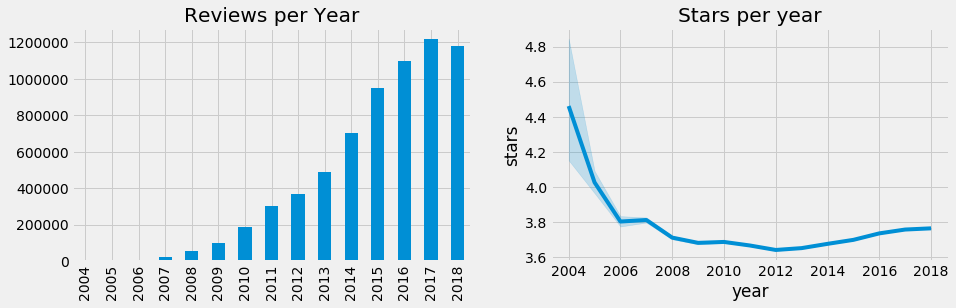

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
combined.year.value_counts().sort_index().plot.bar(title='Reviews per Year', ax=axes[0]);
sns.lineplot(x='year', y='stars', data=combined, ax=axes[1])
axes[1].set_title('Stars per year');

In [15]:
combined.member_yrs.value_counts().sort_index()

0     165419
1     320468
2     575835
3     783098
4     848641
5     848339
6     843802
7     869333
8     613929
9     424050
10    226052
11    119301
12     39268
13      8140
14       225
Name: member_yrs, dtype: int64

In [16]:
combined.stars.value_counts(normalize=True).sort_index().mul(100)

1.0    14.989141
2.0     8.112505
3.0    11.057300
4.0    21.971388
5.0    43.869666
Name: stars, dtype: float64

### Create train-test split

In [17]:
train = combined[combined.year < 2018]
test = combined[combined.year == 2018]

In [19]:
train.to_parquet(parquet_dir / 'train.parquet')
test.to_parquet(parquet_dir / 'test.parquet')

In [20]:
train = pd.read_parquet(parquet_dir / 'train.parquet')
test = pd.read_parquet(parquet_dir / 'test.parquet')

### Benchmark Accuracy

Using the most frequent number of stars (=5) to predict the test set achieve an accuracy close to 51%:

In [21]:
test['predicted'] = train.stars.mode().iloc[0]

In [22]:
accuracy_score(test.stars, test.predicted)

0.5096963305260762

### Create Yelp review document-term matrix

In [23]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=10000)
train_dtm = vectorizer.fit_transform(train.text)
train_dtm

<5508238x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 250524808 stored elements in Compressed Sparse Row format>

In [24]:
sparse.save_npz(text_features_dir / 'train_dtm', train_dtm)

In [25]:
train_dtm = sparse.load_npz(text_features_dir / 'train_dtm.npz')

In [26]:
test_dtm = vectorizer.transform(test.text)
sparse.save_npz(text_features_dir / 'test_dtm', test_dtm)

In [27]:
test_dtm = sparse.load_npz(text_features_dir / 'test_dtm.npz')

### Train Multiclass Naive Bayes

Next, we train a Naive Bayes classifier using a document-term matrix produced by the CountVectorizer with default settings.

In [28]:
nb = MultinomialNB()
nb.fit(train_dtm,train.stars)
predicted_stars = nb.predict(test_dtm)

### Evaluate results

The prediction produces 64.7% accuracy on the test set, a 24.4% improvement over the benchmark:

In [29]:
accuracy_score(test.stars, predicted_stars)

0.6440158551434961

In [30]:
stars = index=list(range(1,6))
pd.DataFrame(confusion_matrix(test.stars, predicted_stars), 
             columns=stars,
             index=stars)

,1,2,3,4,5
1,153289,37619,7355,3023,3896
2,25124,30016,18722,4593,2880
3,11841,17546,39995,23913,6615
4,7871,5717,22960,110209,44228
5,29517,3545,6686,135578,424924



### Combine non-text features with the document-term matrix

The dataset contains various numerical features. The vectorizers produce [scipy.sparse matrices](https://docs.scipy.org/doc/scipy/reference/sparse.html). To combine the vectorized text data with other features, we need to first convert these to sparse matrices as well; many sklearn objects and other libraries like lightgbm can handle these very memory-efficient data structures. Converting the sparse matrix to a dense numpy array risks memory overflow.

Most variables are categorical so we use one-hot encoding since we have a fairly large dataset to accommodate the increase in features.

We convert the encoded numerical features and combine them with the document-term matrix:

#### One-hot-encoding 

In [31]:
df = pd.concat([train.drop(['text', 'stars'], axis=1).assign(source='train'),
                test.drop(['text', 'stars'], axis=1).assign(source='test')])

In [32]:
uniques = df.nunique()
binned = pd.concat([(df.loc[:, uniques[uniques > 20].index]
                     .apply(pd.qcut, q=10, labels=False, duplicates='drop')),
                    df.loc[:, uniques[uniques <= 20].index]], axis=1)
binned.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6685900 entries, 0 to 6685899
Data columns (total 25 columns):
average_stars         6685900 non-null int64
compliment_cool       6685900 non-null int64
compliment_cute       6685900 non-null int64
compliment_funny      6685900 non-null int64
compliment_hot        6685900 non-null int64
compliment_list       6685900 non-null int64
compliment_more       6685900 non-null int64
compliment_note       6685900 non-null int64
compliment_photos     6685900 non-null int64
compliment_plain      6685900 non-null int64
compliment_profile    6685900 non-null int64
compliment_writer     6685900 non-null int64
cool                  6685900 non-null int64
cool_user             6685900 non-null int64
fans                  6685900 non-null int64
funny                 6685900 non-null int64
funny_user            6685900 non-null int64
review_count          6685900 non-null int64
useful                6685900 non-null int64
useful_user           6685900 no

In [36]:
dummies = pd.get_dummies(binned, columns=binned.columns.drop('source'), drop_first=True)
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6685900 entries, 0 to 6685899
Columns: 118 entries, source to year_2018
dtypes: object(1), uint8(117)
memory usage: 848.0+ MB


In [37]:
train_dummies = dummies[dummies.source=='train'].drop('source', axis=1)
train_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5508238 entries, 0 to 6685896
Columns: 117 entries, average_stars_1 to year_2018
dtypes: uint8(117)
memory usage: 656.6 MB


#### Train set

In [38]:
# Cast other feature columns to float and convert to a sparse matrix.
train_numeric = sparse.csr_matrix(train_dummies.astype(np.int8))
train_numeric.shape

(5508238, 117)

In [39]:
# Combine sparse matrices.
train_dtm_numeric = sparse.hstack((train_dtm, train_numeric))
train_dtm_numeric.shape

(5508238, 10117)

In [40]:
sparse.save_npz(text_features_dir / 'train_dtm_numeric', train_dtm_numeric)

#### Repeat for test set

In [41]:
test_dummies = dummies[dummies.source=='test'].drop('source', axis=1)
test_numeric = sparse.csr_matrix(test_dummies.astype(np.int8))
test_dtm_numeric = sparse.hstack((test_dtm, test_numeric))
test_dtm_numeric.shape

(1177662, 10117)

In [42]:
sparse.save_npz(text_features_dir / 'test_dtm_numeric', test_dtm_numeric)

In [43]:
train_dtm_numeric = sparse.load_npz(text_features_dir / 'train_dtm_numeric.npz')
test_dtm_numeric = sparse.load_npz(text_features_dir / 'test_dtm_numeric.npz')

### Logistic Regression

We proceed to train a one-vs-all Logistic Regression that trains one model per class while treating the remaining classes as the negative class and predicts probabilities for each class using the different models.

Using only the text features, we train and evaluate the model as follows:

In [44]:
logreg = LogisticRegression(C=1e9)

#### Text features only

In [ ]:
logreg.fit(X=train_dtm, y=train.stars)
y_pred_class = logreg.predict(test_dtm)

In [ ]:
joblib.dump(logreg, 'train_dtm.joblib') 

In [ ]:
logreg = joblib.load('log_reg_multi/train_dtm.joblib')

In [ ]:
y_pred_class = logreg.predict(test_dtm)

##### Evaluate Results

The model achieves significantly higher accuracy at 73.6%:

In [ ]:
print(accuracy_score(test.stars, y_pred_class))

#### Combined Features

##### One-vs-all Logistic Regression

In [ ]:
# Use logistic regression with all features.
logreg.fit(train_dtm_numeric.astype(float), train.stars)
y_pred_class = logreg.predict(test_dtm_numeric.astype(float))

In [ ]:
joblib.dump(logreg, 'train_dtm_numeric.joblib') 

In [ ]:
accuracy_score(test.stars, y_pred_class)

##### Multinomial Logistic Regression

Logistic regression also provides a multinomial training option that is faster and more accurate than the one-vs-all implementation. We use the lbfgs solver (see sklearn [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for details).

In [ ]:
multi_logreg = LogisticRegression(C=1e9, multi_class='multinomial', solver='lbfgs')
multi_logreg.fit(train_dtm_numeric.astype(float), train.stars)

In [ ]:
joblib.dump(multi_logreg, 'train_dtm_numeric_multi.joblib')

In [ ]:
y_pred_class = multi_logreg.predict(test_dtm_numeric.astype(float))

In this case, tuning of the regularization parameter C did not lead to very significant improvements.

In [ ]:
accuracy_score(test.stars, y_pred_class)

In [ ]:
for solver in ['newton-cg', 'sag', 'saga']:
    start = time()
    multi_logreg = LogisticRegression(C=1e9, multi_class='multinomial', solver=solver)
    multi_logreg.fit(train_dtm_numeric.astype(float), train.stars)
    joblib.dump(multi_logreg, f'train_dtm_numeric_multi_{solver}.joblib')
    y_pred_class = multi_logreg.predict(test_dtm_numeric.astype(float))
    print(f'{solver}: {time()-start:.2f}s | {accuracy_score(test.stars, y_pred_class):.2%}', flush=True)

In [ ]:
for C in [1e7, 1e6, 1e5, 1e4, 1e3, 1e2, 1e1, 1, 0.1,0]:
    start = time()
    multi_logreg = LogisticRegression(C=C, multi_class='multinomial', solver='lbfgs')
    multi_logreg.fit(train_dtm_numeric.astype(float), train.stars)
    joblib.dump(multi_logreg, f'train_dtm_numeric_multi_{int(C*10):d}.joblib')
    y_pred_class = multi_logreg.predict(test_dtm_numeric.astype(float))
    print(f'{C}: {time()-start:.2f}s | {accuracy_score(test.stars, y_pred_class):.2%}', flush=True)

### Gradient Boosting

For illustration, we also train a lightgbm Gradient Boosting tree ensemble with default settings and multiclass objective.

In [ ]:
lgb_train = lgb.Dataset(data=train_dtm_numeric.tocsr().astype(np.float32), 
                        label=train.stars.sub(1), 
                        categorical_feature=list(range(train_dtm_numeric.shape[1])))

In [ ]:
lgb_test = lgb.Dataset(data=test_dtm_numeric.tocsr().astype(np.float32), 
                       label=test.stars.sub(1), 
                       reference=lgb_train)

In [ ]:
param = {'objective':'multiclass', 'num_class': 5}

In [ ]:
booster = lgb.train(params=param, 
                    train_set=lgb_train, 
                    num_boost_round=500, 
                    early_stopping_rounds=20,
                    valid_sets=[lgb_train, lgb_test])

In [ ]:
booster.save_model(str(text_features_dir / 'lgb_model.txt'))

In [ ]:
y_pred_class = booster.predict(test_dtm_numeric.astype(float))

The basic settings did not improve over the multinomial logistic regression, but further parameter tuning remains an unused option.

In [ ]:
accuracy_score(test.stars, y_pred_class.argmax(1) + 1)

In [ ]:
y_pred_class_class_classd_classed_classred

In [ ]:
fi = booster.feature_importance(importance_type='gain')
pd.Series(fi).div(fi.sum()).sort_values(ascending=False).head()

### Naive Bayes

In [ ]:
nb = MultinomialNB()
nb.fit(train_dtm_numeric,train.stars)
predicted_stars = nb.predict(test_dtm_numeric)
accuracy_score(test.stars, predicted_stars)

## Textblob for Sentiment Analysis

In [ ]:
sample_review = combined.text.sample(1).iloc[0]
print(sample_review)

In [ ]:
# Polarity ranges from -1 (most negative) to 1 (most positive).
TextBlob(sample_review).sentiment.polarity

In [ ]:
# Define a function that accepts text and returns the polarity.
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [ ]:
combined['sentiment'] = combined.text.apply(detect_sentiment)

In [ ]:
combined.to_parquet(parquet_dir / 'combined_tb.parquet', compression='gzip')

In [ ]:
sample_reviews = combined[['stars', 'text']].sample(100000)

In [ ]:
# Create a new DataFrame column for sentiment (Warning: SLOW!).
sample_reviews['sentiment'] = sample_reviews.text.apply(detect_sentiment)

In [ ]:
# Box plot of sentiment grouped by stars
sns.boxenplot(x='stars', y='sentiment', data=combined);

In [ ]:
# Widen the column display.
pd.set_option('max_colwidth', 500)

In [ ]:
# Reviews with most negative sentiment
combined[combined.sentiment == -1].text.head()

In [ ]:
# Negative sentiment in a 5-star review
combined[(combined.stars == 5) & (combined.sentiment < -0.3)].head(1)

In [ ]:
# Positive sentiment in a 1-star review
combined.loc[(combined.stars == 1) & (combined.sentiment > 0.5), 'text'].head(1)

In [ ]:
# Reset the column display width.
pd.reset_option('max_colwidth')